# Soft-DTW loss for PyTorch neural network

This notebook is inspired by the notebook of Romain Tavenard about Alignment-based metrics in Machine Learning: 

https://github.com/rtavenar/notebooks-ml4ts/blob/main/03_align4ml_sol.ipynb

The aim here is to use the Soft Dynamic Time Warping metric as a loss function for a PyTorch Neural Network.

# Import the modules

In [35]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
# import time

# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# from celluloid import Camera
# from IPython.display import HTML

# from tslearn.backend import instanciate_backend
# from tslearn.metrics import SoftDTW, soft_dtw_alignment, SquaredEuclidean


import numpy as np
import matplotlib.pyplot as plt
import time
from tslearn.datasets import CachedDatasets
from tslearn.metrics import SoftDTW, SquaredEuclidean

# Load the dataset

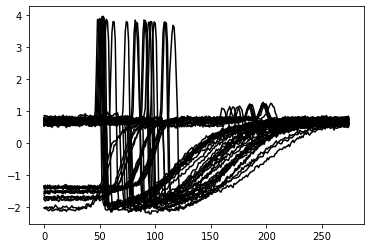

In [36]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

X_subset = X_train[y_train < 4]
np.random.shuffle(X_subset)
X_subset = X_subset[:50]

for ts in X_subset:
    plt.plot(ts[:, 0], color='k')

# Multi-step ahead forecasting

In [37]:
import torch
from torch import nn

class MultiLayerPerceptron(torch.nn.Module):  # No hidden layer here
    def __init__(self, layers, loss=None):
        # At init, we define our layers
        super(MultiLayerPerceptron, self).__init__()
        self.layers = layers
        if loss is None:
            self.loss = torch.nn.MSELoss(reduction="none")
        else:
            self.loss = loss
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
            

    def forward(self, X):
        # The forward method informs about the forward pass: how one computes outputs of the network
        # from the input and the parameters of the layers registered at init
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X)
        batch_size = X.size(0)
        X_reshaped = torch.reshape(X, (batch_size, -1))  # Manipulations to deal with time series format
        output = self.layers(X_reshaped)
        return torch.reshape(output, (batch_size, -1, 1))  # Manipulations to deal with time series format
    
    def fit(self, X, y, max_epochs=10):
        # The fit method performs the actual optimization
        X_torch = torch.Tensor(X)
        y_torch = torch.Tensor(y)

        for e in range(max_epochs):
            self.optimizer.zero_grad()
            # Forward pass
            y_pred = self.forward(X_torch)
            # Compute Loss
            loss = self.loss(y_pred, y_torch).mean()
            if e % 20 == 0:
                print('Epoch {}: train loss: {}'.format(e, loss.item()))
            # Backward pass
            loss.backward()
            self.optimizer.step()

## Example definition of a Multilayer Perceptron model using the class above with PyTorch default loss function

In [38]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    )
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=1000)  # Here one needs to define what X and y are, obviously
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 0.462902307510376
Epoch 20: train loss: 0.4535260796546936
Epoch 40: train loss: 0.44444870948791504
Epoch 60: train loss: 0.4356536269187927
Epoch 80: train loss: 0.4271300137042999
Epoch 100: train loss: 0.4188578426837921
Epoch 120: train loss: 0.4108227789402008
Epoch 140: train loss: 0.40300285816192627
Epoch 160: train loss: 0.3953950107097626
Epoch 180: train loss: 0.38798296451568604
Epoch 200: train loss: 0.3807661831378937
Epoch 220: train loss: 0.37374347448349
Epoch 240: train loss: 0.3668903410434723
Epoch 260: train loss: 0.3602045178413391
Epoch 280: train loss: 0.3536769449710846
Epoch 300: train loss: 0.3473037779331207
Epoch 320: train loss: 0.3410760164260864
Epoch 340: train loss: 0.33498066663742065
Epoch 360: train loss: 0.32900941371917725
Epoch 380: train loss: 0.3231666386127472
Epoch 400: train loss: 0.3174479007720947
Epoch 420: train loss: 0.31184667348861694
Epoch 440: train loss: 0.3063563108444214
Epoch 460: train loss: 0.300976902246

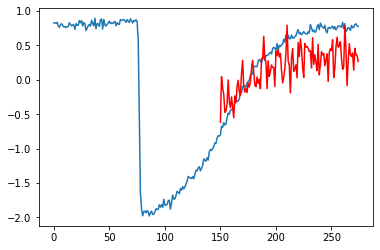

In [39]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

## Multilayer perceptron using Soft-DTW metrics as a loss function

This Soft-DTW class is inspired from: https://github.com/Maghoumi/pytorch-softdtw-cuda/blob/master/soft_dtw_cuda.py

In [40]:
import torch
from torch.autograd import Function
from numba import jit, njit, prange

In [41]:
@jit(nopython=True, parallel=True)
def compute_softdtw(D, gamma, bandwidth):
    B = D.shape[0]
    N = D.shape[1]
    M = D.shape[2]
    R = np.ones((B, N + 2, M + 2)) * np.inf
    R[:, 0, 0] = 0
    for b in prange(B):
        for j in range(1, M + 1):
            for i in range(1, N + 1):

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                r0 = -R[b, i - 1, j - 1] / gamma
                r1 = -R[b, i - 1, j] / gamma
                r2 = -R[b, i, j - 1] / gamma
                rmax = max(max(r0, r1), r2)
                rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
                softmin = - gamma * (np.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin
    return R

# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw_backward(D_, R, gamma, bandwidth):
    B = D_.shape[0]
    N = D_.shape[1]
    M = D_.shape[2]
    D = np.zeros((B, N + 2, M + 2))
    E = np.zeros((B, N + 2, M + 2))
    D[:, 1:N + 1, 1:M + 1] = D_
    E[:, -1, -1] = 1
    R[:, :, -1] = -np.inf
    R[:, -1, :] = -np.inf
    R[:, -1, -1] = R[:, -2, -2]
    for k in prange(B):
        for j in range(M, 0, -1):
            for i in range(N, 0, -1):

                if np.isinf(R[k, i, j]):
                    R[k, i, j] = -np.inf

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                a0 = (R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) / gamma
                b0 = (R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) / gamma
                c0 = (R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) / gamma
                a = np.exp(a0)
                b = np.exp(b0)
                c = np.exp(c0)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c
    return E[:, 1:N + 1, 1:M + 1]

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTWPyTorch(Function):
    """
    CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        bandwidth = torch.Tensor([bandwidth]).to(dev).type(dtype)
        D_ = D.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        R = torch.Tensor(compute_softdtw(D_, g_, b_)).to(dev).type(dtype)
        ctx.save_for_backward(D, R, gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        E = torch.Tensor(compute_softdtw_backward(D_, R_, g_, b_)).to(dev).type(dtype)
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTWPyTorch(torch.nn.Module):
    """
    The soft DTW.
    """

    def __init__(self, gamma=1.0, normalize=False, bandwidth=None, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param gamma: sDTW's gamma parameter
        :param normalize: Flag indicating whether to perform normalization
                          (as discussed in https://github.com/mblondel/soft-dtw/issues/10#issuecomment-383564790)
        :param bandwidth: Sakoe-Chiba bandwidth for pruning. Passing 'None' will disable pruning.
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTWPyTorch, self).__init__()
        self.normalize = normalize
        self.gamma = gamma
        self.bandwidth = 0 if bandwidth is None else float(bandwidth)

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTWPyTorch._euclidean_dist_func

    def _get_func_dtw(self, x, y):
        """
        Checks the inputs and selects the proper implementation to use.
        """
        bx, lx, dx = x.shape
        by, ly, dy = y.shape
        # Make sure the dimensions match
        assert bx == by  # Equal batch sizes
        assert dx == dy  # Equal feature dimensions

        # Finally, return the correct function
        return _SoftDTWPyTorch.apply

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """

        # Check the inputs and get the correct implementation
        func_dtw = self._get_func_dtw(X, Y)

        if self.normalize:
            # Stack everything up and run
            x = torch.cat([X, X, Y])
            y = torch.cat([Y, X, Y])
            D = self.dist_func(x, y)
            out = func_dtw(D, self.gamma, self.bandwidth)
            out_xy, out_xx, out_yy = torch.split(out, X.shape[0])
            return out_xy - 1 / 2 * (out_xx + out_yy)
        else:
            D_xy = self.dist_func(X, Y)
            return func_dtw(D_xy, self.gamma, self.bandwidth)

In [42]:
# sdtw = SoftDTW(D=D, gamma=.1, be="pytorch")

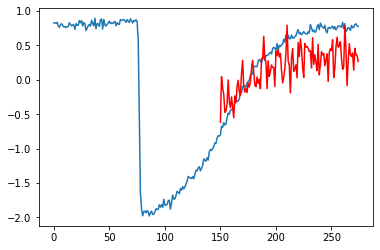

In [43]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

In [44]:
# D = SquaredEuclidean(X_subset.reshape((-1, 1)), X_subset.reshape((-1, 1)))
# sdtw = SoftDTW(D=D, gamma=.1, be="pytorch")
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    ),
    loss=SoftDTWPyTorch(gamma=.1, normalize=False)
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=200)
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 15.361154556274414
Epoch 20: train loss: -6.307930946350098
Epoch 40: train loss: -11.60457992553711
Epoch 60: train loss: -15.117342948913574
Epoch 80: train loss: -16.627281188964844
Epoch 100: train loss: -17.600976943969727
Epoch 120: train loss: -18.260744094848633
Epoch 140: train loss: -18.724754333496094
Epoch 160: train loss: -19.0684871673584
Epoch 180: train loss: -19.344091415405273

 Training time:  6.023205280303955


## Multilayer perceptron using Soft-DTW metrics as a loss function using tslearn functions

https://stackoverflow.com/questions/65754399/conditional-inheritance-based-on-arguments-in-python

https://pytorch-enhance.readthedocs.io/en/latest/_modules/torch/nn/modules/loss.html

In [45]:
# class SoftDTWLoss(torch.nn.Module):
#     pass

In [46]:
# class _SoftDTW:
#     def __init__(self, D, gamma=1.0, be=None, compute_with_backend=False):
#         """
#         Parameters
#         ----------
#         D : array-like, shape=[m, n], dtype=float64 or class computing distances with a method 'compute'
#             Distances. An example of class computing distance is 'SquaredEuclidean'.
#         gamma: float
#             Regularization parameter.
#             Lower is less smoothed (closer to true DTW).
#         be : Backend object or string or None
#             Backend.
#         compute_with_backend : bool, default=False
#             This parameter has no influence when the NumPy backend is used.
#             When using a backend different from NumPy is used:
#             If `True`, the computation is done with the corresponding backend.
#             If `False`, a conversion to the NumPy backend can be used to accelerate the computation.

#         Attributes
#         ----------
#         self.R_: array, shape = [m + 2, n + 2]
#             Accumulated cost matrix (stored after calling `compute`).
#         """
#         be = instanciate_backend(be, D)
#         self.be = be
#         self.compute_with_backend = compute_with_backend
#         if hasattr(D, "compute"):
#             self.D = D.compute()
#         else:
#             self.D = D
#         self.D = self.be.cast(self.D, dtype=self.be.float64)

#         # Allocate memory.
#         # We need +2 because we use indices starting from 1
#         # and to deal with edge cases in the backward recursion.
#         m, n = self.be.shape(self.D)
#         self.R_ = self.be.zeros((m + 2, n + 2), dtype=self.be.float64)
#         self.computed = False

#         self.gamma = self.be.array(gamma, dtype=self.be.float64)

#     def compute(self):
#         """Compute soft-DTW by dynamic programming.

#         Returns
#         -------
#         sdtw: float
#             soft-DTW discrepancy.
#         """
#         m, n = self.be.shape(self.D)

#         if self.be.is_numpy:
#             _njit_soft_dtw(self.D, self.R_, gamma=self.gamma)
#         elif not self.compute_with_backend:
#             _njit_soft_dtw(
#                 self.be.to_numpy(self.D),
#                 self.be.to_numpy(self.R_),
#                 gamma=self.be.to_numpy(self.gamma),
#             )
#             self.R_ = self.be.array(self.R_)
#         else:
#             _soft_dtw(self.D, self.R_, gamma=self.gamma, be=self.be)

#         self.computed = True

#         return self.R_[m, n]

#     def grad(self):
#         """Compute gradient of soft-DTW w.r.t. D by dynamic programming.

#         Returns
#         -------
#         grad: array, shape = [m, n]
#             Gradient w.r.t. D.
#         """
#         if not self.computed:
#             raise ValueError("Needs to call compute() first.")

#         m, n = self.be.shape(self.D)

#         # Add an extra row and an extra column to D.
#         # Needed to deal with edge cases in the recursion.
#         D = self.be.vstack((self.D, self.be.zeros(n)))
#         D = self.be.hstack((D, self.be.zeros((m + 1, 1))))

#         # Allocate memory.
#         # We need +2 because we use indices starting from 1
#         # and to deal with edge cases in the recursion.
#         E = self.be.zeros((m + 2, n + 2), dtype=self.be.float64)

#         if self.be.is_numpy:
#             _njit_soft_dtw_grad(D, self.R_, E, gamma=self.gamma)
#         elif not self.compute_with_backend:
#             _njit_soft_dtw_grad(
#                 self.be.to_numpy(D),
#                 self.be.to_numpy(self.R_),
#                 self.be.to_numpy(E),
#                 gamma=self.be.to_numpy(self.gamma),
#             )
#             self.R_ = self.be.array(self.R_)
#         else:
#             _soft_dtw_grad(D, self.R_, E, gamma=self.gamma, be=self.be)

#         return E[1:-1, 1:-1]

In [47]:
# class SoftDTW:
#     def __init__(self, D, gamma=1.0, be=None, compute_with_backend=False):
#         """
#         Parameters
#         ----------
#         D : array-like, shape=[m, n], dtype=float64 or class computing distances with a method 'compute'
#             Distances. An example of class computing distance is 'SquaredEuclidean'.
#         gamma: float
#             Regularization parameter.
#             Lower is less smoothed (closer to true DTW).
#         be : Backend object or string or None
#             Backend.
#         compute_with_backend : bool, default=False
#             This parameter has no influence when the NumPy backend is used.
#             When using a backend different from NumPy is used:
#             If `True`, the computation is done with the corresponding backend.
#             If `False`, a conversion to the NumPy backend can be used to accelerate the computation.

#         Attributes
#         ----------
#         self.R_: array, shape = [m + 2, n + 2]
#             Accumulated cost matrix (stored after calling `compute`).
#         """
#         be = instanciate_backend(be, D)
#         self.be = be
#         self.compute_with_backend = compute_with_backend
#         if hasattr(D, "compute"):
#             self.D = D.compute()
#         else:
#             self.D = D
#         self.D = self.be.cast(self.D, dtype=self.be.float64)

#         # Allocate memory.
#         # We need +2 because we use indices starting from 1
#         # and to deal with edge cases in the backward recursion.
#         m, n = self.be.shape(self.D)
#         self.R_ = self.be.zeros((m + 2, n + 2), dtype=self.be.float64)
#         self.computed = False
#         self.gamma = self.be.array(gamma, dtype=self.be.float64)
#         self.instance = _SoftDTWPyTorch(D=D, gamma=gamma) if be.is_pytorch else _SoftDTW(D=D, gamma=gamma, be=be, compute_with_backend=compute_with_backend)

#     # called when an attribute is not found:
#     def __getattr__(self, name):
#         # assume it is implemented by self.instance
#         return self.instance.__getattribute__(name)

In [48]:
from tslearn.metrics.soft_dtw_fast import _soft_dtw, _soft_dtw_grad

In [49]:
class _SoftDTWPyTorchTslearn(Function):
    """
    Soft-DTW using PyTorch and tslearn functions.
    """

    @staticmethod
    def forward(ctx, D, gamma):
        dev = D.device
        dtype = D.dtype
        b, m, n = torch.Tensor.size(D)
        R = torch.zeros((b, m + 2, n + 2), dtype=torch.float64)
        for i_sample in range(b):
            _soft_dtw(D[i_sample, :, :], R[i_sample, :, :], gamma, be='pytorch')
        gamma = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        ctx.save_for_backward(D, R, gamma)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        D, R, gamma = ctx.saved_tensors
        b, m, n = torch.Tensor.size(D)
        E = torch.zeros((b, m + 2, n + 2), dtype=torch.float64)
        for i_sample in range(b):
            _soft_dtw_grad(D[i_sample, :, :], R[i_sample, :, :], E[i_sample, :, :], gamma, be='pytorch')
        E = E[:, 1:m + 1, 1:n + 1]
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTWPyTorchTslearn(torch.nn.Module):
    """
    The soft DTW.
    """

    def __init__(self, gamma=1.0, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param gamma: sDTW's gamma parameter
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTWPyTorchTslearn, self).__init__()
        self.gamma = gamma

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTWPyTorchTslearn._euclidean_dist_func

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """
        
        # Check the inputs and get the correct implementation
        D = self._euclidean_dist_func(X, Y)
        return _SoftDTWPyTorchTslearn.apply(D, self.gamma)

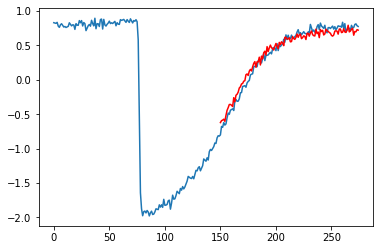

In [50]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

In [51]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    ),
    loss=SoftDTWPyTorchTslearn(gamma=.1)
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=1)
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 24.889506420126228

 Training time:  107.33280062675476


## Using @njit()

In [52]:
from tslearn.metrics.soft_dtw_fast import _njit_soft_dtw, _njit_soft_dtw_grad

In [53]:
class _SoftDTWPyTorchTslearnNjit(Function):
    """
    Soft-DTW using PyTorch and tslearn functions.
    """

    @staticmethod
    def forward(ctx, D, gamma):
        dev = D.device
        dtype = D.dtype
        b, m, n = torch.Tensor.size(D)
        D_ = D.detach().cpu().numpy()
        R_ = np.zeros((b, m + 2, n + 2), dtype=np.float64)
        for i_sample in range(b):
            _njit_soft_dtw(D_[i_sample, :, :], R_[i_sample, :, :], gamma)
        gamma_tensor = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        R = torch.Tensor(R_).to(dev).type(dtype)
        ctx.save_for_backward(D, R, gamma_tensor)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma = ctx.saved_tensors
        b, m, n = torch.Tensor.size(D)
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        E_ = np.zeros((b, m + 2, n + 2), dtype=np.float64)
        for i_sample in range(b):
            _njit_soft_dtw_grad(D_[i_sample, :, :], R_[i_sample, :, :], E_[i_sample, :, :], gamma.item())
        E = torch.Tensor(E_[:, 1:m + 1, 1:n + 1]).to(dev).type(dtype)
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTWPyTorchTslearnNjit(torch.nn.Module):
    """
    The soft DTW.
    """

    def __init__(self, gamma=1.0, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param gamma: sDTW's gamma parameter
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTWPyTorchTslearnNjit, self).__init__()
        self.gamma = gamma

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTWPyTorchTslearnNjit._euclidean_dist_func

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """
        
        # Check the inputs and get the correct implementation
        D = self._euclidean_dist_func(X, Y)
        return _SoftDTWPyTorchTslearnNjit.apply(D, self.gamma)

In [54]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    ),
    loss=SoftDTWPyTorchTslearnNjit(gamma=.1)
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=20)
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 23.880809783935547

 Training time:  2.299281358718872


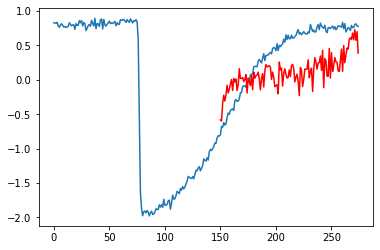

In [55]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

## Using @njit and prange to compute _njit_soft_dtw and _njit_soft_dtw_grad for a complete batch

In [56]:
@njit(parallel=True)
def _njit_soft_dtw_batch(D, R, gamma):
    """Compute soft dynamic time warping.

    Parameters
    ----------
    D : array-like, shape=[b, m, n], dtype=float64
    R : array-like, shape=[b, m+2, n+2], dtype=float64
    gamma : float64
    """
    for i_sample in prange(D.shape[0]):
        _njit_soft_dtw(D[i_sample, :, :], R[i_sample, :, :], gamma)

In [57]:
@njit(parallel=True)
def _njit_soft_dtw_grad_batch(D, R, E, gamma):
    """Compute gradient of soft-DTW w.r.t. D.

    Parameters
    ----------
    D : array-like, shape=[b, m, n], dtype=float64
    R : array-like, shape=[b, m+2, n+2], dtype=float64
    E : array-like, shape=[b, m+2, n+2], dtype=float64
    gamma : float64
    """
    for i_sample in prange(D.shape[0]):
        _njit_soft_dtw_grad(D[i_sample, :, :], R[i_sample, :, :], E[i_sample, :, :], gamma)

In [58]:
class _SoftDTWPyTorchTslearnNjitParallel(Function):
    """
    Soft-DTW using PyTorch and tslearn functions.
    """

    @staticmethod
    def forward(ctx, D, gamma):
        dev = D.device
        dtype = D.dtype
        b, m, n = torch.Tensor.size(D)
        D_ = D.detach().cpu().numpy()
        R_ = np.zeros((b, m + 2, n + 2), dtype=np.float64)
        _njit_soft_dtw_batch(D_, R_, gamma)
        gamma_tensor = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        R = torch.Tensor(R_).to(dev).type(dtype)
        ctx.save_for_backward(D, R, gamma_tensor)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma_tensor = ctx.saved_tensors
        b, m, n = torch.Tensor.size(D)
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        E_ = np.zeros((b, m + 2, n + 2), dtype=np.float64)
        gamma = gamma_tensor.item()
        _njit_soft_dtw_grad_batch(D_, R_, E_, gamma)
        E = torch.Tensor(E_[:, 1:m + 1, 1:n + 1]).to(dev).type(dtype)
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTWPyTorchTslearnNjitParallel(torch.nn.Module):
    """
    The soft DTW.
    """

    def __init__(self, gamma=1.0, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param gamma: sDTW's gamma parameter
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTWPyTorchTslearnNjitParallel, self).__init__()
        self.gamma = gamma

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTWPyTorchTslearnNjitParallel._euclidean_dist_func

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """
        
        # Check the inputs and get the correct implementation
        D = self._euclidean_dist_func(X, Y)
        return _SoftDTWPyTorchTslearnNjitParallel.apply(D, self.gamma)

In [59]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    ),
    loss=SoftDTWPyTorchTslearnNjitParallel(gamma=.1)
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=20)
time_end = time.time()
print('\n Training time: ', time_end - time_start)

Epoch 0: train loss: 19.16490936279297

 Training time:  3.0858097076416016


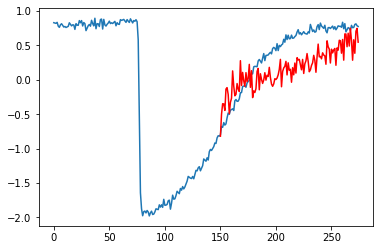

In [60]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()

# Inheritance depending on the backend

In [64]:
from tslearn.backend import instanciate_backend

In [65]:
class SoftDTWLoss(torch.nn.Module):
    def __init__(self, gamma=1.0, dist_func=None, be=None):
        self.be = instanciate_backend(be)
        # assign an instance of A or B depending on whether argument use_A is True
        self.instance = SoftDTWPyTorchTslearnNjitParallel(gamma=1.0, dist_func=None) if self.be.is_pytorch else SoftDTW(be=be)
#         super(self.instance).__init__(gamma=1.0, dist_func=None)
        
    # called when an attribute is not found:
    def __getattr__(self, name):
        # assume it is implemented by self.instance
        return self.instance.__getattribute__(name)

In [66]:
model = MultiLayerPerceptron(
    layers=nn.Sequential(
        nn.Linear(in_features=150, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=125)
    ),
    loss=SoftDTWLoss(gamma=.1, be='pytorch')
)

time_start = time.time()
model.fit(X_subset[:, :150], X_subset[:, 150:], max_epochs=20)
time_end = time.time()
print('\n Training time: ', time_end - time_start)

AttributeError: cannot assign module before Module.__init__() call

In [ ]:
ts_index = 50

y_pred = model(X_test[:, :150, 0]).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()